In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

# Ideal point target data generation

In [170]:
# Single moving target

def generate_trajectory(T=20, dt=0.001, v=5, trajectory_type="sinusoidal"):
    """
    Generate a simulated target trajectory. Ideal Point Target.

    Parameters:
        T (float): Total simulation time in seconds.
        dt (float): Time step in seconds / resolution.
        speed (float): Constant speed of the target in m/s.
        trajectory_type (str): Type of trajectory ("linear", "sinusoidal", "random").

        add RCS in dBsm?

    Returns:
        x, y, vx, vy (numpy arrays)
    """

    num_steps = int(T / dt)

    # Initialize arrays for position and velocity
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    # Initial position
    x[0], y[0] = 0, 20

    # Generate trajectory based on type
    for i in range(1, num_steps):
        x[i] = x[i-1] + v * dt  # Always move forward in x

        if trajectory_type == "linear":
            y[i] = y[i-1]  # Straight line
        elif trajectory_type == "sinusoidal":
            y[i] = 20 + 10 * np.sin(0.1 * x[i])  # Sine wave path
        elif trajectory_type == "random":
            y[i] = y[i-1] + np.random.uniform(-2, 2)  # Random small movements

    # Calculate velocity
    vx = np.gradient(x, dt)
    vy = np.gradient(y, dt)


    return x, y, vx, vy

def plot_trajectory(x, y, title="Simulated Target Motion"):
    """Plot the trajectory."""
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Ground Truth", color="black")
    plt.xlabel("Range [m]")
    plt.ylabel("Range [m]")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

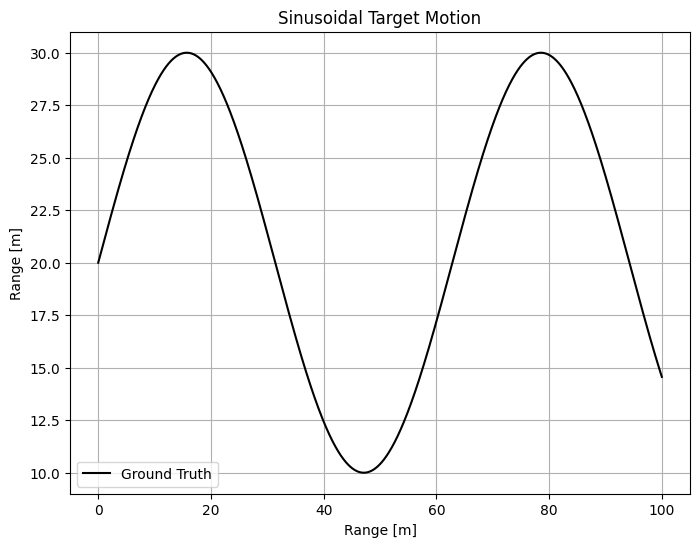

In [171]:
# Example usage
x, y, vx, vy = generate_trajectory(T=20, dt=0.001, v=5, trajectory_type="sinusoidal")
plot_trajectory(x, y, title="Sinusoidal Target Motion")

In [172]:
def radar_to_target(x_target, y_target, x_radar, y_radar, dt=0.001):
    """
    Calculate the range and angle from the radar to the target.

    Parameters:
        x_target, y_target (float): Target position.
        x_radar, y_radar (float): Radar position.

    Returns:
        range (float): Distance from radar to target.
        angle (float): Angle from radar to target.
    """
    N = len(x_target)

    # Initialize arrays for radial range and velocity
    radial_range = np.zeros(N)
    radial_velocity = np.zeros(N)
    
    for i in range(len(x_target)):
        dx = x_target[i] - x_radar
        dy = y_target[i] - y_radar
        radial_range[i] = np.sqrt(dx**2 + dy**2)
        if i == 0:
            radial_velocity[i] = 0
        else:
            radial_velocity[i] = (radial_range[i] - radial_range[i-1]) / dt # radial velocity to target
    return radial_range, radial_velocity

In [173]:
target_range, target_velocity = radar_to_target(x, y, 40, 0, dt=0.001)

# Radar Model - MIMO

In [174]:
# Single Target

target_location = np.array([2, 10]) # Target location on 2-dimensional plane [m]
target_velocity = np.array([5, 5]) # Target velocity in m/s in each dimension [m/s]

In [175]:
# MIMO radar setup

""" TRANSMITTER TXs"""

f_c = 77e9          # start frequency - [Hz]
wavelength = c/f_c  # Lambda wakelength at carrier frequency - [m]

T_c = 25.66e-6      # chirp time/ duration - [s]
bw = 0.77*1e9           # bandwidth eg. from 76. GHz to 77.5 GHz - [Hz]
S = bw/T_c          # chirp rate - [Hz/s]
prf = 1/T_c         # pulse repetition frequency - [Hz]
fs = 20e6           # sampling frequency - [Hz]
Ns = 32            # number of samples (ADC)

M = 32              # number of chirps

TX_locations = np.array([-6e-3, 0])    # Transmitter location on 2-dimensional plane [m]

                                    # TI har 3 transmitter
                                    # Unilateral antenna array: 1 lambda spacing between antennas


""" RECEIVER RXs"""

RX_locations = np.array(([3e-3, 0],
                        [6e-3, 0]))#,
                       #[9e-3, 0],
                       #[12e-3, 0]))  # Receiver location on 2-dimensional plane [m]
    
                                    # TI har 4 receiver
                                    # Unilateral antenna array: 1/2 lambda spacing between antennas

In [176]:
print(f"wavelength: {wavelength} m \n chirp_rate: {S} Hz/s \n prf: {prf} Hz \n TX_locations: {TX_locations} m \n RX_locations: {RX_locations} m")

print(f"range resolution: {c/(2*bw)} m")

wavelength: 0.0038934085454545454 m 
 chirp_rate: 30007794232268.12 Hz/s 
 prf: 38971.16134060795 Hz 
 TX_locations: [-0.006  0.   ] m 
 RX_locations: [[0.003 0.   ]
 [0.006 0.   ]] m
range resolution: 0.19467042727272726 m


In [177]:
def compute_radial_velocity(x_target, y_target, x_base, y_base, x_velocity, y_velocity):
    dx = x_target - x_base
    dy = y_target - y_base
    distance = np.sqrt(dx**2 + dy**2)
    radial_velocity = (dx * x_velocity + dy * y_velocity) / distance
    return radial_velocity

In [178]:
def compute_radial_distance(target_loc, TX_loc, RX_loc):
    RX_to_target = np.zeros(len(RX_loc))
    TX_to_target = np.sqrt((target_loc[0]-TX_loc[0])**2 + (target_location[1]-TX_loc[1])**2)

    for i in range(len(RX_loc)):
        RX_to_target[i] = np.sqrt((target_loc[0]-RX_loc[i][0])**2 + (target_location[1]-RX_loc[i][1])**2)
    #RX_to_target = np.sqrt((target_loc[0]-RX_loc[0])**2 + (target_location[1]-RX_loc[1])**2)

    return TX_to_target, RX_to_target

tx_target, rx_target = compute_radial_distance(target_location, TX_locations, RX_locations)

In [179]:
dist_to_target = np.zeros(len(RX_locations))    # distance from target to each receiver - radial range [m]
time_from_dist = np.zeros(len(RX_locations))    # EM-wave propagation time from target to each receiver [s]
time_from_vel = np.zeros(len(RX_locations))     # time shift from chirp to chirp due to velocity!
time_elapsed = np.zeros(len(RX_locations))


for i in range(len(RX_locations)):
    dist_to_target[i] = np.sqrt((target_location[0]-RX_locations[i,0])**2 + (target_location[1]-RX_locations[i,1])**2)
    time_from_dist[i] =  dist_to_target[i]/c
    time_from_vel[i] = 2*(compute_radial_velocity(target_location[0], target_location[1], RX_locations[i,0], RX_locations[i,1], target_velocity[0], target_velocity[1])*T_c)/c
    time_elapsed[i] = time_from_dist[i] + time_from_vel[i]
    print(f"Proppagation time for RX {i+1}: {time_elapsed[i]*1e9:.7f} ns")

Proppagation time for RX 1: 34.0160425 ns
Proppagation time for RX 2: 34.0140840 ns


In [180]:
compute_radial_velocity(target_location[0], target_location[1], RX_locations[0,0], RX_locations[0,1], target_velocity[0], target_velocity[1])

np.float64(5.882352304861555)

Simulating target in range and Doppler

In [181]:
def compute_phase_diff(time_from_velocity):
    phase_diff = np.zeros(len(RX_locations))
    for i in range(len(RX_locations)):
        phase_diff[i] = 2*pi*f_c*time_from_velocity[i]
    return phase_diff

def compute_phase_diff_antennas():
    phase_diff = np.zeros(len(RX_locations))
    for i in range(len(RX_locations)):
        phase_diff[i] = (2*pi*(rx_target[i]))/wavelength % (2*pi)
    return phase_diff

def compute_intermediate_frequencies():
    IF = np.zeros(len(RX_locations))
    for i in range(len(RX_locations)):
        IF[i] = (S*(tx_target+rx_target[i]))/ c
    return IF


In [182]:
intermediate_freq = compute_intermediate_frequencies() # Hz
phase_diff = compute_phase_diff(time_from_vel) # rad
phase_diff_antennas = compute_phase_diff_antennas()

intermediate_freq, phase_diff

for i in intermediate_freq:
    print(f"Intermediate frequency: {i/1e6:.9f} MHz")
for i in phase_diff:
    print(f"Phase delta: {i:.9f} rad")
for i in phase_diff_antennas:
    print(f"Phase delta antennas: {i:.9f} rad")

Intermediate frequency: 2.041609172 MHz
Intermediate frequency: 2.041550409 MHz
Phase delta: 0.487177890 rad
Phase delta: 0.487084107 rad
Phase delta antennas: 0.991071379 rad
Phase delta antennas: 0.043648763 rad


In [183]:
max_range = (20e6*c)/(2*S) # m
range_res = c / (2*bw) # m

print(f"Max range: {max_range:.2f} m")
print(f"Range resolution: {range_res:.2f} m/s")

(fs*c)/(2*S)

Max range: 99.90 m
Range resolution: 0.19 m/s


99.90486327636364

In [184]:
max_vel = wavelength / (4 * T_c) # m/s
vel_res = wavelength / (2 * M * T_c) # m/s

print(f"Maximum velocity: {max_vel:.2f} m/s")
print(f"Velocity resolution: {vel_res:.2f} m/s")

Maximum velocity: 37.93 m/s
Velocity resolution: 2.37 m/s


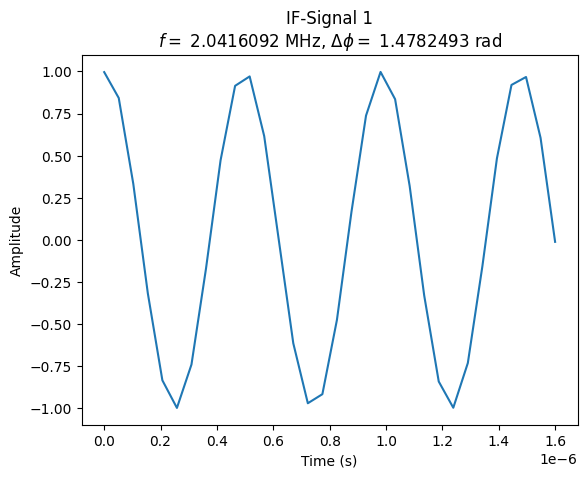

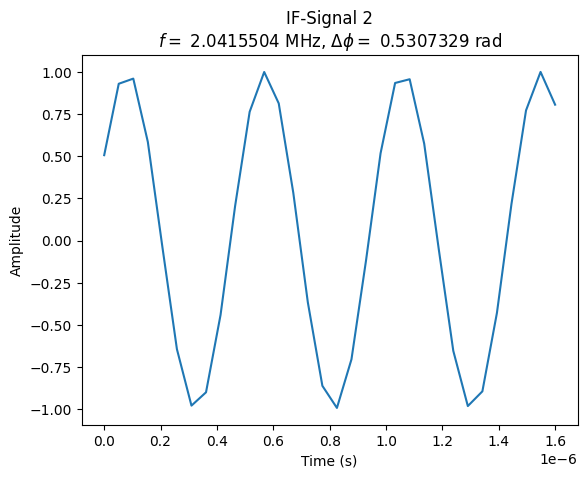

In [185]:
for i in range(len(intermediate_freq)):
    t = np.linspace(0, Ns/fs, Ns)

    if_signal = np.sin(2 * pi * intermediate_freq[i] * t + phase_diff[i] + phase_diff_antennas[i])

    plt.plot(t, if_signal)
    plt.title(
        f"IF-Signal {i+1}\n"
        f"$f=\\ ${intermediate_freq[i]/1e6:.7f} MHz, $\\Delta \\phi =\\ ${phase_diff[i] + phase_diff_antennas[i]:.7f} rad"
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

c:\Users\malth\miniconda3\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\malth\miniconda3\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


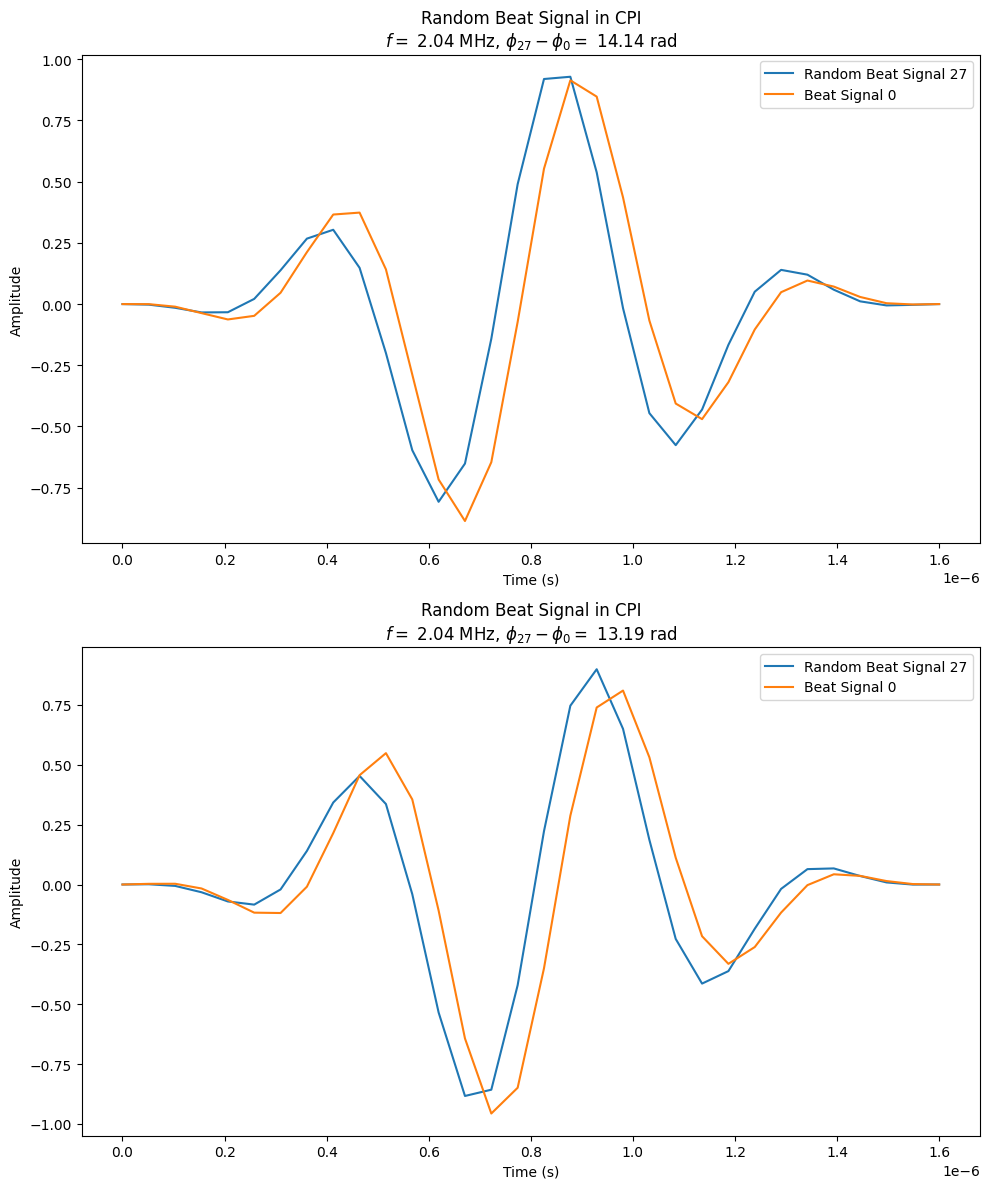

In [186]:
# FRAME

fig, axs = plt.subplots(len(intermediate_freq), 1, figsize=(10, 6 * len(intermediate_freq)))

n = np.random.randint(0, M - 1)
frame = {}

for idx in range(len(intermediate_freq)):
    window = signal.windows.blackman(Ns)
    chirp = np.array(
        [
            (
                np.exp(1j * (2 * pi * intermediate_freq[idx] * t + m * phase_diff[idx] + phase_diff_antennas[idx]))# + np.random.normal(0, 0.5, Ns)
            )
            * window
            for m in range(M)
        ]
    )
    frame[idx] = chirp

    axs[idx].plot(t, chirp[n], label=f'Random Beat Signal {n}')
    axs[idx].plot(t, chirp[0], label='Beat Signal 0')
    axs[idx].set_title(
        f"Random Beat Signal in CPI\n"
        f"$f=\\ ${intermediate_freq[idx]/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff[idx] + phase_diff_antennas[idx]:.2f} rad"
    )
    axs[idx].set_xlabel("Time (s)")
    axs[idx].set_ylabel("Amplitude")
    axs[idx].legend()

plt.tight_layout()
plt.show()

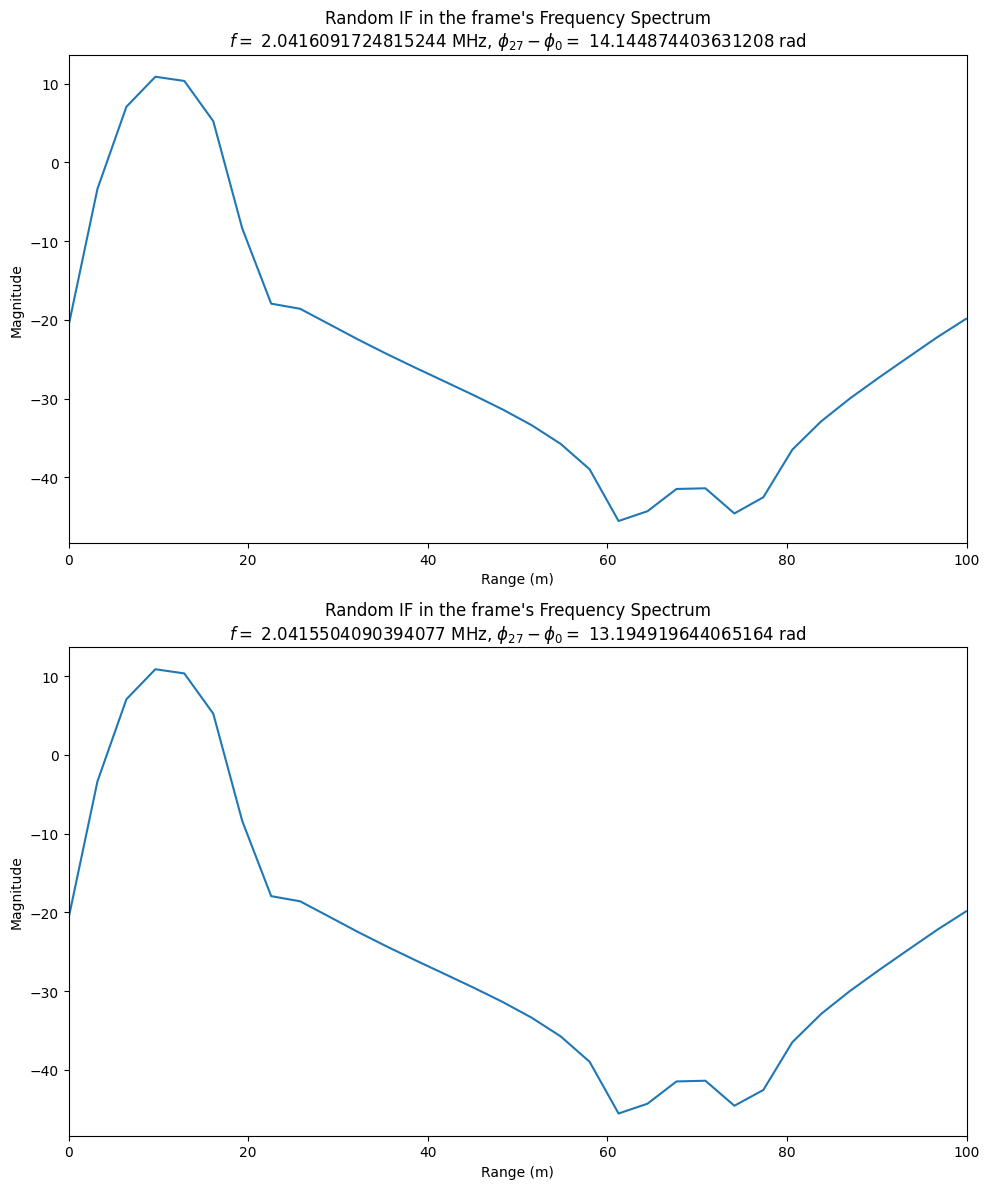

In [187]:

freq = np.linspace(-fs / 2, fs / 2, Ns)

ranges = np.linspace(0, max_range, Ns)

fig, axs = plt.subplots(len(frame), 1, figsize=(10, 6 * len(frame)))

for idx, chirp in frame.items():
    X_k = np.fft.fft(chirp[n])
#    X_k /= Ns / 2
    X_k = np.abs(X_k)
    X_k = 10 * np.log10(X_k)

    axs[idx].set_title(
        f"Random IF in the frame's Frequency Spectrum\n"
        f"$f=\\ ${intermediate_freq[idx]/1e6} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff[idx] + phase_diff_antennas[idx]} rad"
    )

    # Uncomment to plot over frequency axis instead
    # axs[idx].plot(freq / 1e6, X_k)
    # axs[idx].set_xlabel("Frequency (MHz)")
    axs[idx].plot(ranges, X_k)
    axs[idx].set_xlabel("Range (m)")

    axs[idx].set_ylabel("Magnitude")
    axs[idx].set_xlim([0, 100])

plt.tight_layout()
plt.show()

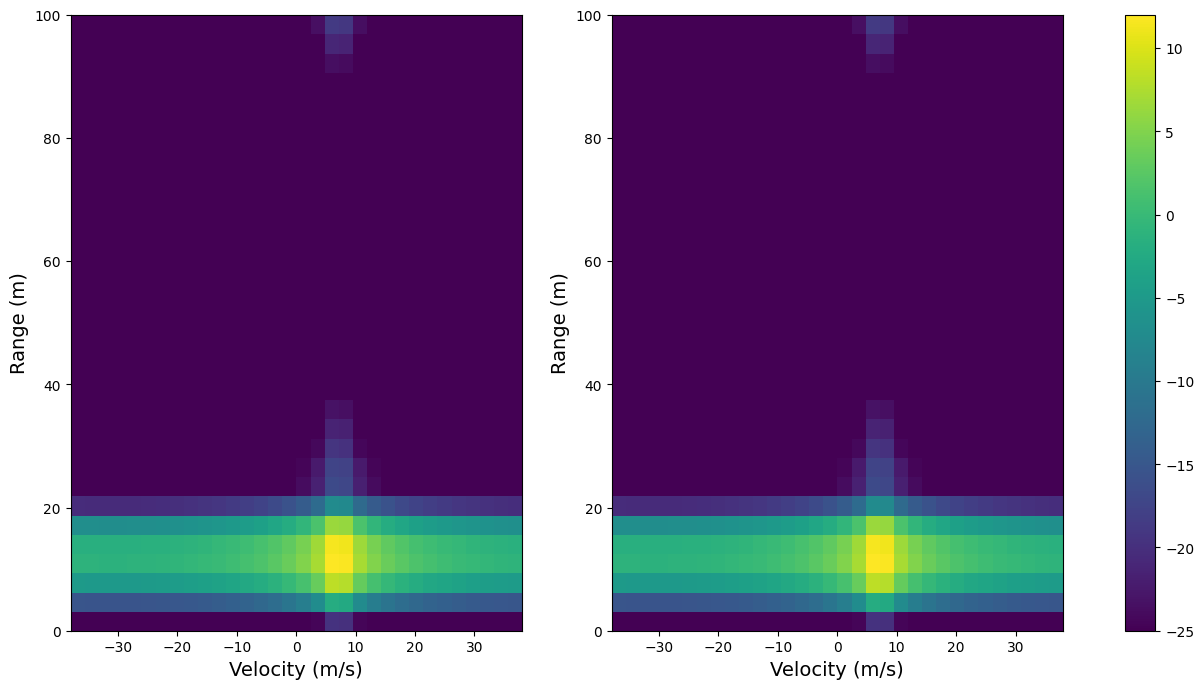

In [188]:
fig, axs = plt.subplots(1, len(frame), figsize=(16, 8))

range_doppler_rxs = {}

for idx, (key, chirp) in enumerate(frame.items()):
    range_doppler = np.fft.fftshift(np.fft.fft2(chirp.T),axes=1) / (Ns / 2)
    range_doppler_rxs[idx] = range_doppler

    """
    -   np.fft.fft2(chirp.T): Computes the 2D FFT, which is naturally complex.
    -   np.fft.fftshift(...): Shifts the zero-frequency component to the center.
    -   / (N / 2): Normalizes the values.
    """
    extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

    range_doppler_plot = axs[idx].imshow(
        10 * np.log10(np.abs(range_doppler)), # np.abs(...): Takes the magnitude, removing the phase.
        aspect="auto",
        extent=extent,
        origin="lower",
        vmax=12,
        vmin=-25,
    )
    axs[idx].set_ylim([0, 100])
    axs[idx].set_xlabel("Velocity (m/s)", fontsize=14)
    axs[idx].set_ylabel("Range (m)", fontsize=14)

fig.colorbar(range_doppler_plot, ax=axs, orientation='vertical')
plt.show()

# CHIRPS on velocity axis, ADC samples on range axis

In [189]:
target_summed_rx1 = range_doppler_rxs[0][3][18] + range_doppler_rxs[0][4][18] + range_doppler_rxs[0][3][19] + range_doppler_rxs[0][4][19]
target_summed_rx2 = range_doppler_rxs[1][3][18] + range_doppler_rxs[1][4][18] + range_doppler_rxs[1][3][19] + range_doppler_rxs[1][4][19]

In [196]:
# omega - phase difference
phase_diff = np.angle(target_summed_rx2) - np.angle(target_summed_rx1)

# Calculate the angle
theta = np.arcsin((wavelength * phase_diff) / (2 * np.pi * (np.abs(RX_locations[0,0]-RX_locations[1,0]))))

print(phase_diff, theta, np.degrees(theta))

-0.9366681920740176 -0.19469819746220238 -11.155384993388912


In [191]:
def extract_phasor(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)
    print(peak_index)

    # Extract phasor at the peak position
    phasor = fft_2d[peak_index]

    return phasor


phasors = np.array([extract_phasor(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])


(np.int64(3), np.int64(18))
(np.int64(3), np.int64(18))


In [192]:
def angle_fft(phasors, d, lamda, plot=True):
    """
    Compute the Angle FFT to estimate the Direction of Arrival (DOA).
    
    Parameters:
    phasors : np.array
        Complex phasors corresponding to the 2D FFT peaks for each receiver.
    d : float
        Distance between the receiving antennas.
    lamda : float
        Wavelength of the transmitted signal.
    plot : bool, optional
        If True, plots the FFT magnitude spectrum. Default is True.
    
    Returns:
    theta : float
        Estimated angle of arrival (DOA) in degrees.
    """
    # Compute the FFT along the antenna elements    

    angle_spectrum = np.fft.fft(phasors)
    angle_spectrum = np.abs(angle_spectrum)
    angle_spectrum = 10 * np.log10(angle_spectrum)
    print(angle_spectrum)
    
    # Compute the corresponding spatial frequency axis
    N = len(phasors)
    omega = np.fft.fftshift(np.fft.fftfreq(N, d=1)) * 2 * np.pi  # Normalize to radians
    
    # Find the peak in the FFT spectrum
    peak_index = np.argmax(np.abs(angle_spectrum))
    omega_peak = omega[peak_index]
    
    # Compute the DOA using the given formula
    theta = np.arcsin((lamda * omega_peak) / (2 * np.pi * d))
    theta_deg = np.degrees(theta)
    
    # Plot the FFT magnitude spectrum if requested
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(angle_spectrum, 'b')
        plt.xlabel('Angle (degrees)')
        plt.ylabel('Magnitude')
        plt.title('Angle FFT Spectrum')
        plt.grid()
        plt.show()
    
    return theta_deg


[14.57533424 11.68284158]


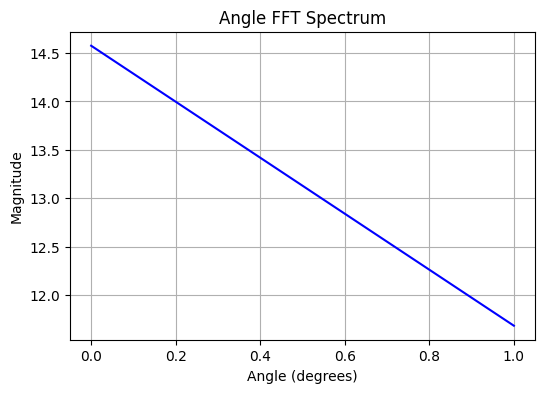

Estimated DOA: -40.458825090 degrees


In [193]:
# Example usage
d = 0.003  # Example inter-antenna spacing in meters
lamda = wavelength  # Example wavelength in meters

theta_estimate = angle_fft(phasors, d, lamda, plot=True)
print(f"Estimated DOA: {theta_estimate:.9f} degrees")

# Troubleshooting phasors

In [194]:
# omega - phase difference
phase_rx1 = np.angle(phasors[0])  # Phase of RX1
phase_rx2 = np.angle(phasors[1])  # Phase of RX2

# Use phase unwrapping to correct for wrapping issues
phase_diff = np.unwrap([phase_rx2, phase_rx1])[1] - np.unwrap([phase_rx2, phase_rx1])[0]
#phase_diff = 2*np.pi - (np.angle(phasors[1]) - np.angle(phasors[0]))

# Calculate the angle
theta = np.arcsin((wavelength * phase_diff) / (2 * np.pi * (np.abs(RX_locations[0,0]-RX_locations[1,0]))))

print(phase_diff, theta, np.degrees(theta))

0.9491716310834293 0.19733122633461667 11.30624643511434
